In [38]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from imblearn.over_sampling import RandomOverSampler

In [39]:
current_year = int(os.getenv('current_year'))
teams_df = pd.read_csv("scaled_teams_itm.csv")
points_df = pd.read_csv("scaled_points.csv")
scaled_games_df = pd.read_csv("scaled_games.csv")

In [40]:
teams_df = teams_df[['year', 'abbrev', 'id', 'record.overall.wins', 'record.overall.losses', 'record.overall.pointsFor', 'record.overall.pointsAgainst', 'scaled_pointsFor', 'scaled_pointsAgainst', 'itm' ]]
teams_df.rename(columns={'record.overall.wins': 'wins', 'record.overall.losses': 'losses', 'record.overall.pointsFor': 'pointsFor', 'record.overall.pointsAgainst': 'pointsAgainst'}, inplace=True)
#teams_df.set_index(['year', 'id'], inplace=True)
teams_df.head()

,year,abbrev,id,wins,losses,pointsFor,pointsAgainst,scaled_pointsFor,scaled_pointsAgainst,itm
0,2021,Caw,1,8,6,2064.3,1765.6,1.210171,-0.909638,0.0
1,2021,TOTY,2,7,7,1901.1,1934.5,0.281015,0.873910,0.0
2,2021,Sith,3,5,9,1605.7,1791.6,-1.400804,-0.635083,0.0
3,2021,TMB,7,4,10,1588.3,1931.4,-1.499869,0.841175,0.0
4,2021,Mill,9,5,9,1622.7,1809.5,-1.304017,-0.446063,0.0


In [41]:
points_df.head()

,year,team_id,diff,scaled_diff
0,2018,1,-1409.7,-2.356939
1,2018,2,-454.3,0.581335
2,2018,3,-321.4,0.990060
3,2018,7,-362.9,0.862430
4,2018,9,-546.5,0.297779


In [42]:
#with_points = teams_df.join(points_df.set_index(['year', 'team_id']), how='inner', on=['year', 'team_id'])
with_points = teams_df.merge(points_df, left_on=['year', 'id'], right_on=['year', 'team_id'])

In [43]:
with_points.head()

,year,abbrev,id,wins,losses,pointsFor,pointsAgainst,scaled_pointsFor,scaled_pointsAgainst,itm,team_id,diff,scaled_diff
0,2021,Caw,1,8,6,2064.3,1765.6,1.210171,-0.909638,0.0,1,-215.6,-0.070950
1,2021,TOTY,2,7,7,1901.1,1934.5,0.281015,0.873910,0.0,2,-475.8,-0.384383
2,2021,Sith,3,5,9,1605.7,1791.6,-1.400804,-0.635083,0.0,3,-462.9,-0.368844
3,2021,TMB,7,4,10,1588.3,1931.4,-1.499869,0.841175,0.0,7,-608.7,-0.544472
4,2021,Mill,9,5,9,1622.7,1809.5,-1.304017,-0.446063,0.0,9,-318.6,-0.195022


In [44]:
with_games = with_points.merge(scaled_games_df, left_on=['year', 'id'], right_on=['year', 'Team'])

In [45]:
with_games.head()

,year,abbrev,id,wins,losses,pointsFor,pointsAgainst,scaled_pointsFor,scaled_pointsAgainst,itm,team_id,diff,scaled_diff,Team,lucky_win,unlucky_loss,scaled_lucky_win,scaled_unlucky_loss
0,2021,Caw,1,8,6,2064.3,1765.6,1.210171,-0.909638,0.0,1,-215.6,-0.070950,1,0,1,-1.559779,-0.707107
1,2021,TOTY,2,7,7,1901.1,1934.5,0.281015,0.873910,0.0,2,-475.8,-0.384383,2,3,3,0.251577,1.414214
2,2021,Sith,3,5,9,1605.7,1791.6,-1.400804,-0.635083,0.0,3,-462.9,-0.368844,3,6,1,2.062934,-0.707107
3,2021,TMB,7,4,10,1588.3,1931.4,-1.499869,0.841175,0.0,7,-608.7,-0.544472,7,4,1,0.855363,-0.707107
4,2021,Mill,9,5,9,1622.7,1809.5,-1.304017,-0.446063,0.0,9,-318.6,-0.195022,9,2,1,-0.352208,-0.707107


In [46]:
just_itm = with_games[with_games['year'] != current_year]
X = just_itm[['wins', 'losses', 'scaled_pointsFor', 'scaled_pointsAgainst', 'scaled_diff', 'scaled_lucky_win', 'scaled_unlucky_loss']]
y = just_itm['itm']

ros_over = RandomOverSampler(random_state=10)
os_X, os_y = ros_over.fit_resample(X,  y)

X_train, X_test, y_train, y_test = train_test_split(os_X, os_y, test_size = 0.20)

In [47]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train.values.ravel())

MLPClassifier(hidden_layer_sizes=(10, 10, 10, 10), max_iter=1000)

In [48]:
cur_teams = with_games[with_games['year'] == current_year]
X_cur = cur_teams[['wins', 'losses', 'scaled_pointsFor', 'scaled_pointsAgainst', 'scaled_diff', 'scaled_lucky_win', 'scaled_unlucky_loss']]

In [49]:
predictions = mlp.predict(X_test)

In [50]:
predictions

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.])

In [51]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[3 1]
 [0 8]]
              precision    recall  f1-score   support

         0.0       1.00      0.75      0.86         4
         1.0       0.89      1.00      0.94         8

    accuracy                           0.92        12
   macro avg       0.94      0.88      0.90        12
weighted avg       0.93      0.92      0.91        12



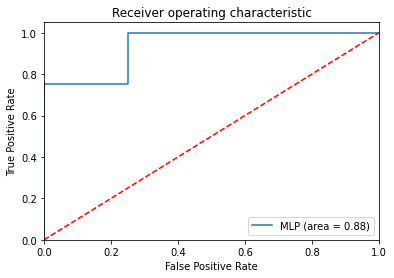

In [52]:
ml_roc_auc = roc_auc_score(y_test, mlp.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, mlp.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='MLP (area = %0.2f)' % ml_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [53]:
cur_predictions = mlp.predict(X_cur)

In [54]:
cur_teams["pred_itm"] = cur_predictions
cur_teams[['id', 'abbrev', 'wins', 'losses', 'pred_itm']].head(12)

/tmp/ipykernel_868/1077995852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_teams["pred_itm"] = cur_predictions


,id,abbrev,wins,losses,pred_itm
0,1,Caw,8,6,0.0
1,2,TOTY,7,7,0.0
2,3,Sith,5,9,0.0
3,7,TMB,4,10,0.0
4,9,Mill,5,9,0.0
5,10,BD,9,5,0.0
6,12,Rock,7,7,0.0
7,13,2021,10,4,1.0
8,15,faq,7,7,0.0
9,16,JJJ,3,11,0.0
